## Library Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from IPython.display import display as display

# Function definition

In [134]:
def describe_data(df):
  print(f"\n Dataset Shape: {df.shape}")
  #summary = df.describe(include=['O'])
  #display(summary)
  print(f"\n Columns: {df.info()}")
  print(f"\n Duplicate Rows: {df.duplicated().sum()}")
  print(f"\n Null Values: \n{df.isnull().sum()}")

In [5]:
def plot_distribution(df):
  plt.figure(figsize=(5, 3))
  sns.countplot(data=df, x='class', hue='class', palette='PuRd', legend=False)
  plt.title('Distribución de Clases')
  plt.xlabel('Clases')
  plt.ylabel('Cantidad')
  plt.show()

In [6]:
def plot_correlation_matrix(df):
  correlation_matrix = df.corr(numeric_only=True)
  plt.figure(figsize=(10, 8))
  sns.heatmap(correlation_matrix, annot=True, cmap='PuRd', fmt=".2f", square=True)
  plt.title('Correlation Heatmap')
  plt.show()
  return correlation_matrix

In [41]:
def high_correlation_features(correlation_matrix, threshold):
  corr_pairs = correlation_matrix.abs().unstack().sort_values(ascending=False)
  high_corr = corr_pairs[(corr_pairs < 1.0) & (corr_pairs > threshold)]
  print(f"High Correlated Features \n{high_corr}")

In [10]:
def label_encoding_data(df):
  label_encoder = LabelEncoder()
  for column in df.select_dtypes(include=['object']).columns:
    df[column] = label_encoder.fit_transform(df[column])
  return df

In [11]:
def one_hot_encoding_data(df):
  object_columns = df.select_dtypes(include='object').columns
  binary_columns = [column for column in object_columns if df[column].nunique()<= 2]
  multi_columns = [column for column in object_columns if df[column].nunique() > 2]

  print("Binary columns:", binary_columns)
  print("Multi-class columns:", multi_columns)

  label_encoder = LabelEncoder()
  for column in binary_columns:
      df[column] = label_encoder.fit_transform(df[column])

  onehot_encoder = OneHotEncoder(sparse_output=False)
  for column in multi_columns:
      encoded_array = onehot_encoder.fit_transform(df[[column]])
      encoded_df = pd.DataFrame(
          encoded_array,
          columns=onehot_encoder.get_feature_names_out([column]),
          index=df.index
      )
      df = df.drop(columns=[column])
      df = pd.concat([df, encoded_df], axis=1)

  display(df.head())
  print(df.select_dtypes(include='object').columns)
  return df

In [16]:
def data_splitting(df):
  x = df.drop(columns=['class'])
  y = df['class']
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, train_size=0.8, random_state=1)
  print(f"x_train shape: {x_train.shape}")
  print(f"x_test shape: {x_test.shape}")
  print(f"y_train shape: {y_train.shape}")
  print(f"y_test shape: {y_test.shape}")
  return x_train, x_test, y_train, y_test

In [17]:
def min_max_scaling(df):
  scaled_df = MinMaxScaler().fit_transform(df)
  scaled_df = pd.DataFrame(scaled_df, columns=df.columns)
  display(scaled_df.head())
  return scaled_df

In [44]:
def get_model(input_shape):
    model  =  Sequential([
                    Dense(128, activation='relu',input_shape=(input_shape[1],)),
                    Dense(1, activation='sigmoid')
    ])
    return model

In [45]:
def compile_model(model):
    model.compile(optimizer= "adam", loss = "binary_crossentropy", metrics=['accuracy'])

In [173]:
def train_model(model, scaled_x_train, y_train):
    history = model.fit(scaled_x_train, y_train, epochs = 100)
    return history

In [50]:
def evaluate_model(model, scaled_x_test, y_test):
  prediction_probabilities = model.predict(scaled_x_test)
  prediction_classes = (prediction_probabilities > 0.5).astype(int)
  prediction_classes = prediction_classes.flatten()
  confusion_matrix_model = confusion_matrix(y_test, prediction_classes)
  print("Confusion Matrix:")
  print(confusion_matrix_model)
  print("Classification report \n", classification_report(y_test, prediction_classes))
  return confusion_matrix_model

In [51]:
def plot_confusion_matrix(confusion_matrix_model):
  labels = ['edible','poisonous']
  display_matrix = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_model, display_labels=labels)
  display_matrix.plot(cmap='PuRd')
  plt.show()

# Data Analysis

In [165]:
df = pd.read_csv('secondary_data.csv', sep=';')
describe_data(df)


 Dataset Shape: (61069, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   obj

## Data Plots

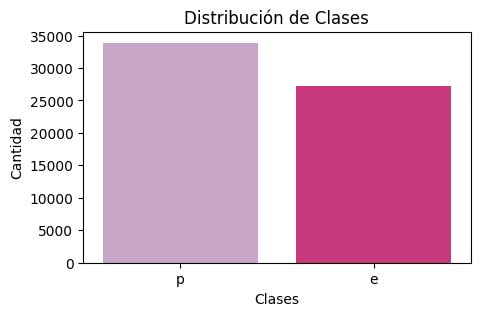

In [105]:
plot_distribution(df)

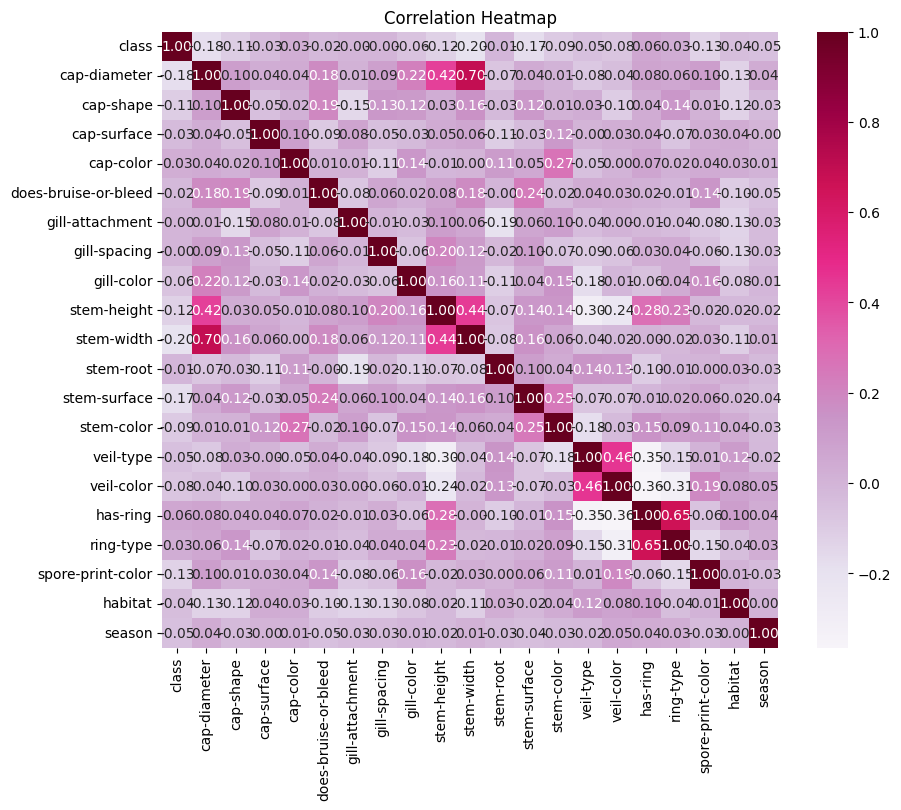

High Correlated Features 
cap-diameter  stem-width      0.695330
stem-width    cap-diameter    0.695330
has-ring      ring-type       0.653726
ring-type     has-ring        0.653726
dtype: float64


In [106]:
threshold = 0.65
label_encoder_df = label_encoding_data(df)
correlation_matrix = plot_correlation_matrix(label_encoder_df)
high_correlation_features(correlation_matrix, threshold)

# Simple Model

## Preprocessing and Data Spliting

In [43]:
x_train_simple, x_test_simple, y_train_simple, y_test_simple = data_splitting(label_encoder_df)
min_max_scaled_x_train_simple = min_max_scaling(x_train_simple)
min_max_scaled_x_test_simple = min_max_scaling(x_test_simple)

x_train shape: (48847, 20)
x_test shape: (12212, 20)
y_train shape: (48847,)
y_test shape: (12212,)


,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0.051808,0.333333,0.000000,0.454545,1.0,0.142857,0.000000,0.636364,0.138561,0.059859,1.0,1.000,0.25,1.0,1.0,0.0,0.125,1.000000,0.000000,0.000000
1,0.044868,1.000000,0.272727,0.363636,0.0,0.714286,0.000000,0.454545,0.149175,0.064094,1.0,0.875,0.50,1.0,1.0,1.0,0.000,0.714286,0.571429,0.000000
2,0.148644,1.000000,0.727273,0.454545,1.0,0.571429,1.000000,1.000000,0.160377,0.200751,1.0,1.000,0.50,1.0,1.0,0.0,0.125,1.000000,0.000000,0.666667
3,0.024371,0.666667,0.727273,0.454545,0.0,0.000000,0.000000,0.454545,0.173939,0.023097,1.0,0.750,1.00,1.0,1.0,1.0,0.000,1.000000,0.571429,0.333333
4,0.035830,0.833333,0.909091,0.454545,0.0,0.000000,0.333333,0.636364,0.182488,0.036378,1.0,0.375,0.50,1.0,1.0,0.0,0.125,1.000000,0.428571,0.666667


,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0.007481,0.000000,0.727273,0.454545,0.0,1.000000,0.000000,0.272727,0.094899,0.023776,1.0,1.000,0.500000,1.0,1.0,1.0,0.125,1.000000,0.571429,0.0
1,0.074809,0.000000,0.272727,0.454545,0.0,1.000000,1.000000,0.454545,0.319692,0.060204,1.0,1.000,0.916667,1.0,1.0,1.0,1.000,0.142857,0.142857,1.0
2,0.043145,0.500000,1.000000,0.272727,0.0,0.428571,0.666667,0.181818,0.090154,0.138163,1.0,0.125,0.500000,1.0,1.0,0.0,0.125,1.000000,0.000000,0.0
3,0.074113,0.333333,0.727273,0.545455,0.0,0.000000,0.333333,1.000000,0.223013,0.057857,1.0,0.625,0.583333,1.0,1.0,0.0,0.125,1.000000,0.000000,0.0
4,0.028358,1.000000,0.363636,0.272727,0.0,0.000000,1.000000,0.909091,0.116251,0.026837,1.0,1.000,0.916667,1.0,1.0,0.0,0.125,0.428571,0.142857,0.0


## Compiling the model

In [48]:
model_nn_simple = get_model(min_max_scaled_x_train_simple.shape)
model_nn_simple.summary()
compile_model(model_nn_simple)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,817 (11.00 KB)

 Trainable params: 2,817 (11.00 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
predicthistory_simple = train_model(model_nn_simple, min_max_scaled_x_train_simple, y_train_simple)

Epoch 1/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6492 - loss: 0.6140
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8372 - loss: 0.3961
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9025 - loss: 0.2887
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9270 - loss: 0.2272
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9435 - loss: 0.1825
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9574 - loss: 0.1501
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9700 - loss: 0.1226
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9764 - loss: 0.1054
Epoch 9/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9812 - loss: 0.0871
Epoch 10/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9843 - loss: 0.0754


## Model Evaluation

In [52]:
confusion_matrix_model_nn_simple = evaluate_model(model_nn_simple, min_max_scaled_x_test_simple, y_test_simple)

382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Confusion Matrix:
[[5433   40]
 [ 139 6600]]
Classification report 
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      5473
           1       0.99      0.98      0.99      6739

    accuracy                           0.99     12212
   macro avg       0.98      0.99      0.99     12212
weighted avg       0.99      0.99      0.99     12212



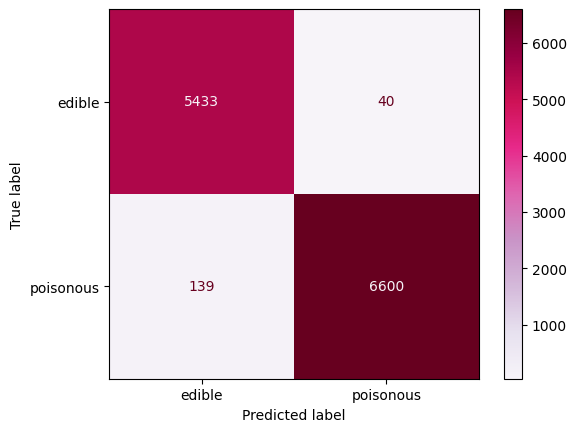

In [53]:
plot_confusion_matrix(confusion_matrix_model_nn_simple)

# Model with One Hot Enconding

## Preprocessing and data spliting

In [166]:
df = one_hot_encoding_data(df)
df_prompt_complete = df.sample(n=10, random_state=1)
df.drop(df_prompt_complete.index, inplace=True)
df_prompt_complete.to_csv('mushroom_prompt_complete.csv', index=False)
describe_data(df)

Binary columns: ['class', 'does-bruise-or-bleed', 'veil-type', 'has-ring']
Multi-class columns: ['cap-shape', 'cap-surface', 'cap-color', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-color', 'ring-type', 'spore-print-color', 'habitat', 'season']


,class,cap-diameter,does-bruise-or-bleed,stem-height,stem-width,veil-type,has-ring,cap-shape_b,cap-shape_c,cap-shape_f,...,habitat_h,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w,season_a,season_s,season_u,season_w
0,1,15.26,0,16.95,17.09,0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,16.60,0,17.99,18.19,0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,14.07,0,17.80,17.74,0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,14.17,0,15.77,15.98,0,1,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,14.64,0,16.53,17.20,0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Index([], dtype='object')

 Dataset Shape: (61059, 126)
<class 'pandas.core.frame.DataFrame'>
Index: 61059 entries, 0 to 61068
Columns: 126 entries, class to season_w
dtypes: float64(122), int64(4)
memory usage: 59.2 MB

 Columns: None

 Duplicate Rows: 146

 Null Values: 
class                   0
cap-diameter            0
does-bruise-or-bleed    0
stem-height             0
stem-width              0
                       ..
habitat_w               0
season_a                0
season_s                0
season_u                0
season_w                0
Length: 126, dtype: int64


In [156]:
x_train_one_hot, x_test_one_hot, y_train_one_hot, y_test_one_hot = data_splitting(df)
min_max_scaled_x_train_one_hot = min_max_scaling(x_train_one_hot)
min_max_scaled_x_test_one_hot = min_max_scaling(x_test_one_hot)

Binary columns: ['class', 'does-bruise-or-bleed', 'veil-type', 'has-ring']
Multi-class columns: ['cap-shape', 'cap-surface', 'cap-color', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-color', 'ring-type', 'spore-print-color', 'habitat', 'season']


,class,cap-diameter,does-bruise-or-bleed,stem-height,stem-width,veil-type,has-ring,cap-shape_b,cap-shape_c,cap-shape_f,...,habitat_h,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w,season_a,season_s,season_u,season_w
0,1,15.26,0,16.95,17.09,0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,16.60,0,17.99,18.19,0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,14.07,0,17.80,17.74,0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,14.17,0,15.77,15.98,0,1,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,14.64,0,16.53,17.20,0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Index([], dtype='object')
x_train shape: (48847, 125)
x_test shape: (12212, 125)
y_train shape: (48847,)
y_test shape: (12212,)


,cap-diameter,does-bruise-or-bleed,stem-height,stem-width,veil-type,has-ring,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_o,...,habitat_h,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w,season_a,season_s,season_u,season_w
0,0.052292,1.0,0.122642,0.062747,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.053906,0.0,0.160377,0.065922,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.174629,1.0,0.248821,0.221153,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.023564,0.0,0.197229,0.025214,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.047611,0.0,0.200177,0.036281,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


,cap-diameter,does-bruise-or-bleed,stem-height,stem-width,veil-type,has-ring,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_o,...,habitat_h,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w,season_a,season_s,season_u,season_w
0,0.004158,0.0,0.086002,0.023620,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.052841,0.0,0.237544,0.061664,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.038462,0.0,0.102610,0.146321,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.067394,0.0,0.156880,0.046823,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.022349,0.0,0.112693,0.026860,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Compiling the NN Model

In [174]:
model_nn_one_hot = get_model(min_max_scaled_x_train_one_hot.shape)
model_nn_one_hot.summary()
compile_model(model_nn_one_hot)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │        16,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,257 (63.50 KB)

 Trainable params: 16,257 (63.50 KB)

 Non-trainable params: 0 (0.00 B)

In [175]:
predicthistory_one_hot = train_model(model_nn_one_hot, min_max_scaled_x_train_one_hot, y_train_one_hot)

Epoch 1/100
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8761 - loss: 0.3004
Epoch 2/100
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9994 - loss: 0.0111
Epoch 3/100
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9994 - loss: 0.0037
Epoch 4/100
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9993 - loss: 0.0023
Epoch 5/100
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9994 - loss: 0.0020
Epoch 6/100
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9996 - loss: 0.0014
Epoch 7/100
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9996 - loss: 0.0011
Epoch 8/100
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9997 - loss: 7.4851e-04
Epoch 9/100
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9994 - loss: 0.0015
Epoch 10/100
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9995 - loss: 0.0013
Epoch 11/100
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9996 - loss: 0.0011
Epoch 12/100
15

## Model Evaluation

In [176]:
confusion_matrix_model_nn_one_hot = evaluate_model(model_nn_one_hot, min_max_scaled_x_test_one_hot, y_test_one_hot)

382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Confusion Matrix:
[[5469    0]
 [   0 6743]]
Classification report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5469
           1       1.00      1.00      1.00      6743

    accuracy                           1.00     12212
   macro avg       1.00      1.00      1.00     12212
weighted avg       1.00      1.00      1.00     12212



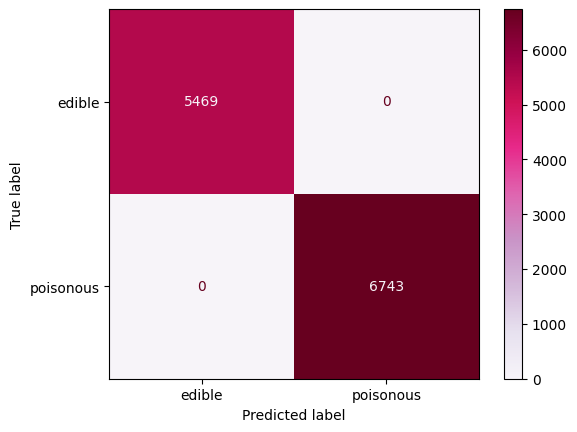

In [177]:
plot_confusion_matrix(confusion_matrix_model_nn_one_hot)

# Reduced Model

In [137]:
reduced_df = df.copy()
reduced_df.drop(columns=['stem-root', 'veil-type', 'veil-color', 'spore-print-color'], inplace=True)
display(reduced_df.head())

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-surface,stem-color,has-ring,ring-type,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,17.09,y,w,t,g,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,18.19,y,w,t,g,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,17.74,y,w,t,g,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,15.98,y,w,t,p,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,17.20,y,w,t,p,d,w


In [119]:
reduced_df_simple = reduced_df.copy()
reduced_df_simple = label_encoding_data(reduced_df_simple)
x = reduced_df_simple.drop(columns=['class'])
y = reduced_df_simple['class']

chi_scores = chi2(x, y)
chi_df = pd.DataFrame({
    'Feature': x.columns,
    'Chi2Score': chi_scores[0],
    'PValue': chi_scores[1]
}).sort_values(by='Chi2Score', ascending=False)

display(chi_df)

,Feature,Chi2Score,PValue
9,stem-width,19720.924557,0.000000e+00
0,cap-diameter,8247.956024,0.000000e+00
8,stem-height,1558.001245,0.000000e+00
10,stem-surface,1236.570197,6.881351e-271
1,cap-shape,781.030569,7.184866e-172
11,stem-color,674.073234,1.299576e-148
7,gill-color,311.317123,1.127977e-69
14,habitat,275.752988,6.325846e-62
15,season,205.129648,1.586707e-46
12,has-ring,152.036457,6.220970e-35


In [120]:
chi_threshold = 700
significant_features = chi_df[chi_df['Chi2Score'] > chi_threshold]['Feature'].values
print(significant_features)
print(significant_features.shape)

['stem-width' 'cap-diameter' 'stem-height' 'stem-surface' 'cap-shape']
(5,)


In [138]:
reduced_df = reduced_df[significant_features]
reduced_df['class'] = df['class']

<ipython-input-138-0c73a67c43bf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df['class'] = df['class']


In [139]:
reduced_df = one_hot_encoding_data(reduced_df)

Binary columns: ['class']
Multi-class columns: ['stem-surface', 'cap-shape']


,stem-width,cap-diameter,stem-height,class,stem-surface_f,stem-surface_g,stem-surface_h,stem-surface_i,stem-surface_k,stem-surface_s,stem-surface_t,stem-surface_y,stem-surface_nan,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_o,cap-shape_p,cap-shape_s,cap-shape_x
0,17.09,15.26,16.95,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,18.19,16.60,17.99,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,17.74,14.07,17.80,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,15.98,14.17,15.77,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,17.20,14.64,16.53,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Index([], dtype='object')


In [140]:
prompt_df = reduced_df.sample(n=10, random_state=1)
reduced_df.drop(prompt_df.index, inplace=True)
prompt_df.to_csv('mushroom_prompt.csv', index=False)
display(reduced_df.head())
describe_data(reduced_df)

,stem-width,cap-diameter,stem-height,class,stem-surface_f,stem-surface_g,stem-surface_h,stem-surface_i,stem-surface_k,stem-surface_s,stem-surface_t,stem-surface_y,stem-surface_nan,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_o,cap-shape_p,cap-shape_s,cap-shape_x
0,17.09,15.26,16.95,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,18.19,16.60,17.99,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,17.74,14.07,17.80,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,15.98,14.17,15.77,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,17.20,14.64,16.53,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0



 Dataset Shape: (61059, 20)
<class 'pandas.core.frame.DataFrame'>
Index: 61059 entries, 0 to 61068
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   stem-width        61059 non-null  float64
 1   cap-diameter      61059 non-null  float64
 2   stem-height       61059 non-null  float64
 3   class             61059 non-null  int64  
 4   stem-surface_f    61059 non-null  float64
 5   stem-surface_g    61059 non-null  float64
 6   stem-surface_h    61059 non-null  float64
 7   stem-surface_i    61059 non-null  float64
 8   stem-surface_k    61059 non-null  float64
 9   stem-surface_s    61059 non-null  float64
 10  stem-surface_t    61059 non-null  float64
 11  stem-surface_y    61059 non-null  float64
 12  stem-surface_nan  61059 non-null  float64
 13  cap-shape_b       61059 non-null  float64
 14  cap-shape_c       61059 non-null  float64
 15  cap-shape_f       61059 non-null  float64
 16  cap-shape_o     

In [141]:
x_train_reduced, x_test_reduced, y_train_reduced, y_test_reduced = data_splitting(reduced_df)
min_max_scaled_x_train_reduced = min_max_scaling(x_train_reduced)
min_max_scaled_x_test_reduced = min_max_scaling(x_test_reduced)

x_train shape: (48847, 19)
x_test shape: (12212, 19)
y_train shape: (48847,)
y_test shape: (12212,)


,stem-width,cap-diameter,stem-height,stem-surface_f,stem-surface_g,stem-surface_h,stem-surface_i,stem-surface_k,stem-surface_s,stem-surface_t,stem-surface_y,stem-surface_nan,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_o,cap-shape_p,cap-shape_s,cap-shape_x
0,0.062747,0.052292,0.122642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.065922,0.053906,0.160377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.221153,0.174629,0.248821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.025214,0.023564,0.197229,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.036281,0.047611,0.200177,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


,stem-width,cap-diameter,stem-height,stem-surface_f,stem-surface_g,stem-surface_h,stem-surface_i,stem-surface_k,stem-surface_s,stem-surface_t,stem-surface_y,stem-surface_nan,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_o,cap-shape_p,cap-shape_s,cap-shape_x
0,0.023620,0.004158,0.086002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.061664,0.052841,0.237544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.146321,0.038462,0.102610,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.046823,0.067394,0.156880,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.026860,0.022349,0.112693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [142]:
model_reduced_nn = get_model(min_max_scaled_x_train_reduced.shape)
model_reduced_nn.summary()
compile_model(model_reduced_nn)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

In [143]:
predicthistory_reduced = train_model(model_reduced_nn, min_max_scaled_x_train_reduced, y_train_reduced)

Epoch 1/100
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6489 - loss: 0.6122
Epoch 2/100
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7297 - loss: 0.5280
Epoch 3/100
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7496 - loss: 0.4959
Epoch 4/100
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7568 - loss: 0.4798
Epoch 5/100
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7719 - loss: 0.4636
Epoch 6/100
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7788 - loss: 0.4508
Epoch 7/100
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7844 - loss: 0.4457
Epoch 8/100
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7874 - loss: 0.4375
Epoch 9/100
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7860 - loss: 0.4351
Epoch 10/100
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7922 - loss: 0.4274
Epoch 11/100
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7941 - loss: 0.4228
Epoch 12/100
1527/1

In [144]:
confusion_matrix_model_reduced = evaluate_model(model_reduced_nn, min_max_scaled_x_test_reduced, y_test_reduced)

382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Confusion Matrix:
[[4844  625]
 [1081 5662]]
Classification report 
               precision    recall  f1-score   support

           0       0.82      0.89      0.85      5469
           1       0.90      0.84      0.87      6743

    accuracy                           0.86     12212
   macro avg       0.86      0.86      0.86     12212
weighted avg       0.86      0.86      0.86     12212



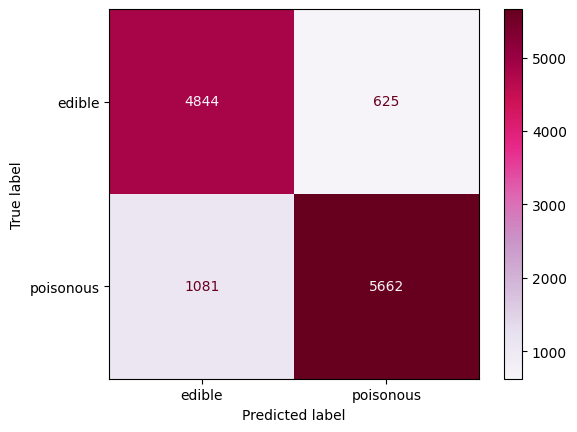

In [145]:
plot_confusion_matrix(confusion_matrix_model_reduced)

# Prompt Evaluation

In [167]:
df_prompt_complete = pd.read_csv('mushroom_prompt_complete.csv', sep=',')
describe_data(df_prompt_complete)


 Dataset Shape: (10, 126)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Columns: 126 entries, class to season_w
dtypes: float64(122), int64(4)
memory usage: 10.0 KB

 Columns: None

 Duplicate Rows: 0

 Null Values: 
class                   0
cap-diameter            0
does-bruise-or-bleed    0
stem-height             0
stem-width              0
                       ..
habitat_w               0
season_a                0
season_s                0
season_u                0
season_w                0
Length: 126, dtype: int64


In [150]:
df_prompt = pd.read_csv('mushroom_prompt.csv', sep=',')
describe_data(df_prompt)


 Dataset Shape: (10, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   stem-width        10 non-null     float64
 1   cap-diameter      10 non-null     float64
 2   stem-height       10 non-null     float64
 3   class             10 non-null     int64  
 4   stem-surface_f    10 non-null     float64
 5   stem-surface_g    10 non-null     float64
 6   stem-surface_h    10 non-null     float64
 7   stem-surface_i    10 non-null     float64
 8   stem-surface_k    10 non-null     float64
 9   stem-surface_s    10 non-null     float64
 10  stem-surface_t    10 non-null     float64
 11  stem-surface_y    10 non-null     float64
 12  stem-surface_nan  10 non-null     float64
 13  cap-shape_b       10 non-null     float64
 14  cap-shape_c       10 non-null     float64
 15  cap-shape_f       10 non-null     float64
 16  cap-shape_o       10 

In [169]:
x_complete = min_max_scaling(df_prompt_complete.drop(columns=['class']))
y_complete = df_prompt_complete['class']

,cap-diameter,does-bruise-or-bleed,stem-height,stem-width,veil-type,has-ring,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_o,...,habitat_h,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w,season_a,season_s,season_u,season_w
0,0.056653,0.0,0.420368,0.049565,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.575099,0.0,0.173348,0.735528,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.000000,0.0,0.121343,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.227931,0.0,0.192849,0.209232,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.127800,0.0,0.000000,0.175558,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [178]:
confusion_matrix_prompt_one_hot = evaluate_model(model_nn_one_hot, x_complete, y_complete)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Confusion Matrix:
[[2 3]
 [0 5]]
Classification report 
               precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.62      1.00      0.77         5

    accuracy                           0.70        10
   macro avg       0.81      0.70      0.67        10
weighted avg       0.81      0.70      0.67        10



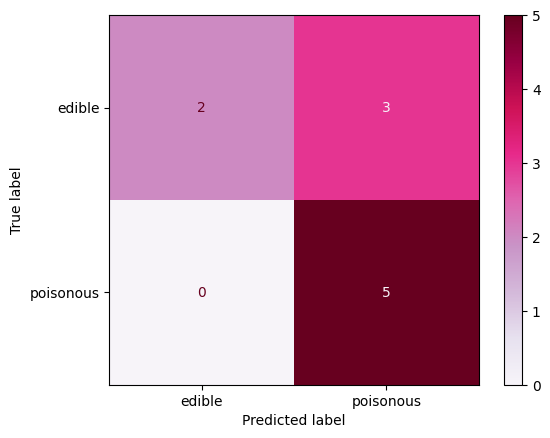

In [179]:
plot_confusion_matrix(confusion_matrix_prompt_one_hot)

In [151]:
x = min_max_scaling(df_prompt.drop(columns=['class']))
y = df_prompt['class']

,stem-width,cap-diameter,stem-height,stem-surface_f,stem-surface_g,stem-surface_h,stem-surface_i,stem-surface_k,stem-surface_s,stem-surface_t,stem-surface_y,stem-surface_nan,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_o,cap-shape_p,cap-shape_s,cap-shape_x
0,0.049565,0.056653,0.420368,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.735528,0.575099,0.173348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.121343,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.209232,0.227931,0.192849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.175558,0.127800,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [152]:
confusion_matrix_prompt = evaluate_model(model_reduced_nn, x, y)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Confusion Matrix:
[[3 2]
 [1 4]]
Classification report 
               precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.67      0.80      0.73         5

    accuracy                           0.70        10
   macro avg       0.71      0.70      0.70        10
weighted avg       0.71      0.70      0.70        10



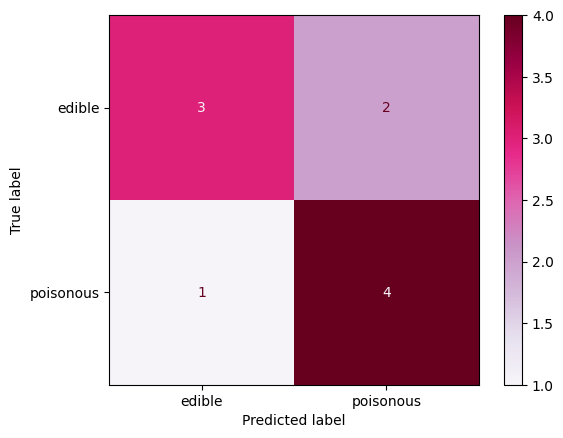

In [171]:
plot_confusion_matrix(confusion_matrix_prompt)